In [3]:
library(plyr)
library(dplyr)
library(forecast)
library(data.table)
library(tseries)
options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [4]:
user_balance=read.csv("./Data/user_balance_table.csv")
user_balance$report_date=as.Date(as.character(user_balance$report_date),format="%Y%m%d")

temp=order(user_balance$report_date)
user_balance=user_balance[temp,]

data=ddply(user_balance,.(report_date),function(D){ colwise(sum)(D[,c(-1,-2)])})

train_data = data[274:396,]
test_data = data[397:427,]

In [5]:
get_score<- function(purchase_pred,redeem_pred,purchase_true,redeem_true,h=0.3){
  out = data.frame(purchase_pred ,redeem_pred,purchase_true,redeem_true )
  
  out$purchase_mape = abs(out$purchase_pred-out$purchase_true)/
    out$purchase_true
  out$redeem_mape = abs(out$redeem_pred-out$redeem_true)/
    out$redeem_true
  
  score = sum(exp(-out$purchase_mape/h)*10)* 0.45 + 
    sum(exp(-out$redeem_mape/h)*10)* 0.55 
  return(score)
}

In [6]:
#####purchase
purchase_ts=ts(train_data$total_purchase_amt,
               frequency=7,start=c(1,1))##生成时间序列
purchase_stl_res = stl(purchase_ts,s.window="periodic",robust=TRUE)##stl分解
purchase_pred_test = forecast(purchase_stl_res,h = 31)$mean##得到测试集预测结果



#####redeem
redeem_ts = ts(train_data$total_redeem_amt,
               frequency=7,start=c(1,1))
redeem_stl_res = stl(redeem_ts,s.window="periodic",robust=TRUE)
redeem_pred_test = forecast(redeem_stl_res,h = 31)$mean


get_score(purchase_pred_test,redeem_pred_test,test_data$total_purchase_amt,
          test_data$total_redeem_amt)


[1] 109.5781

In [7]:
purchase_del_ts=ts(purchase_ts-purchase_stl_res$time.series[,1],
                   frequency=7,start=c(1,1))

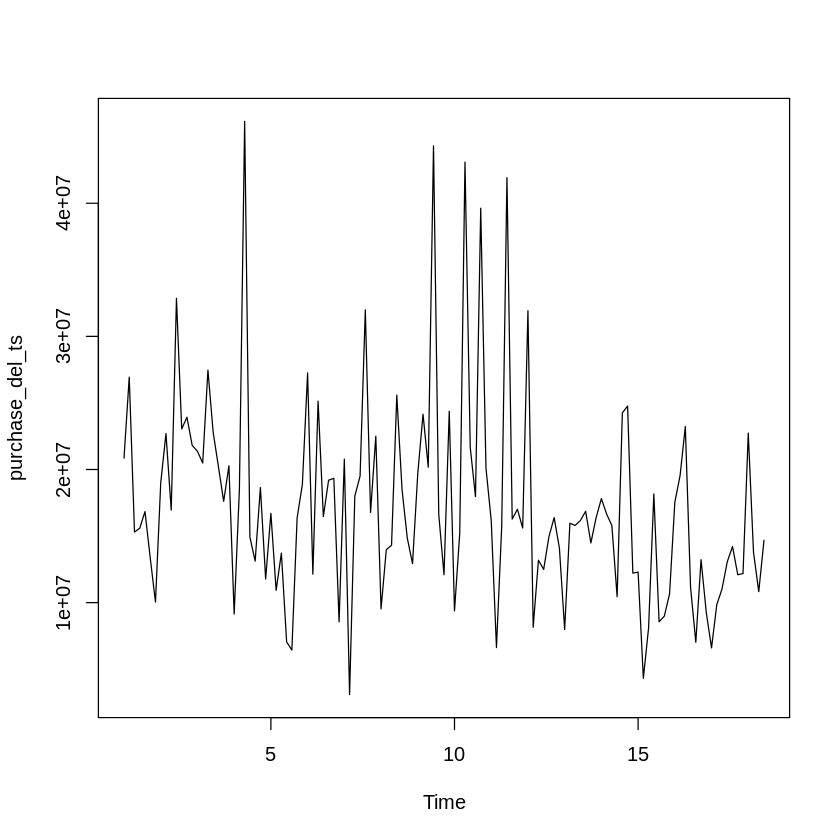

In [8]:
plot(purchase_del_ts)

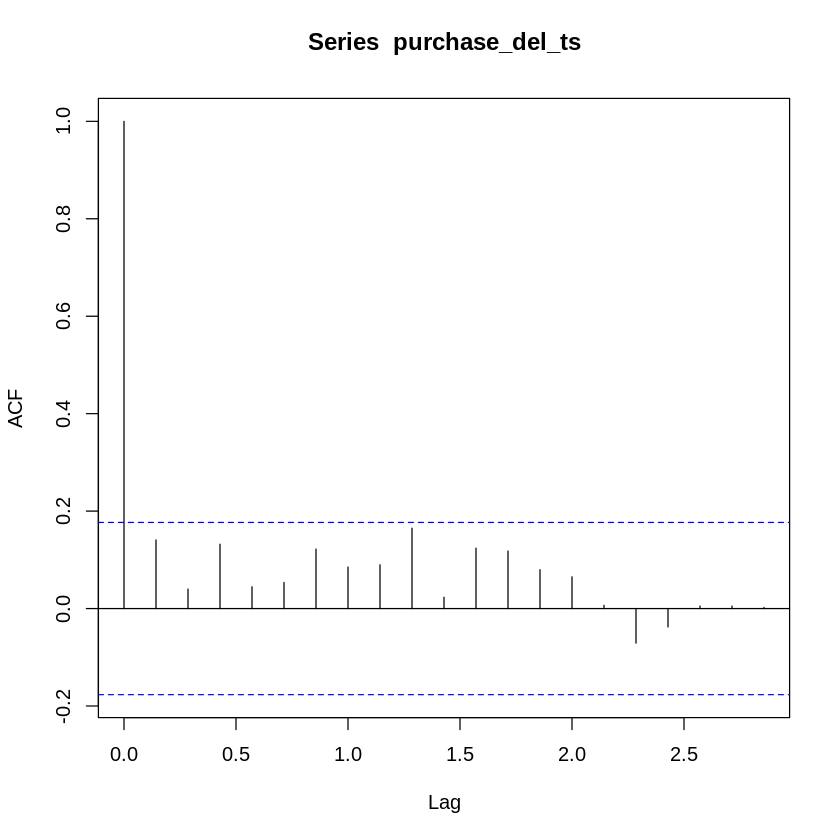

In [9]:
acf(purchase_del_ts)

In [10]:
adf.test(purchase_del_ts)


	Augmented Dickey-Fuller Test

data:  purchase_del_ts
Dickey-Fuller = -4.6386, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


In [11]:
for(i in 1:2){print(Box.test(purchase_del_ts,type = "Box-Pierce",
                             lag = i*6)$p.value)}
for(i in 1:2){print(Box.test(purchase_del_ts,type = "Ljung-Box",
                             lag = i*6)$p.value)}

[1] 0.3016162
[1] 0.1861437
[1] 0.2748159
[1] 0.1369807


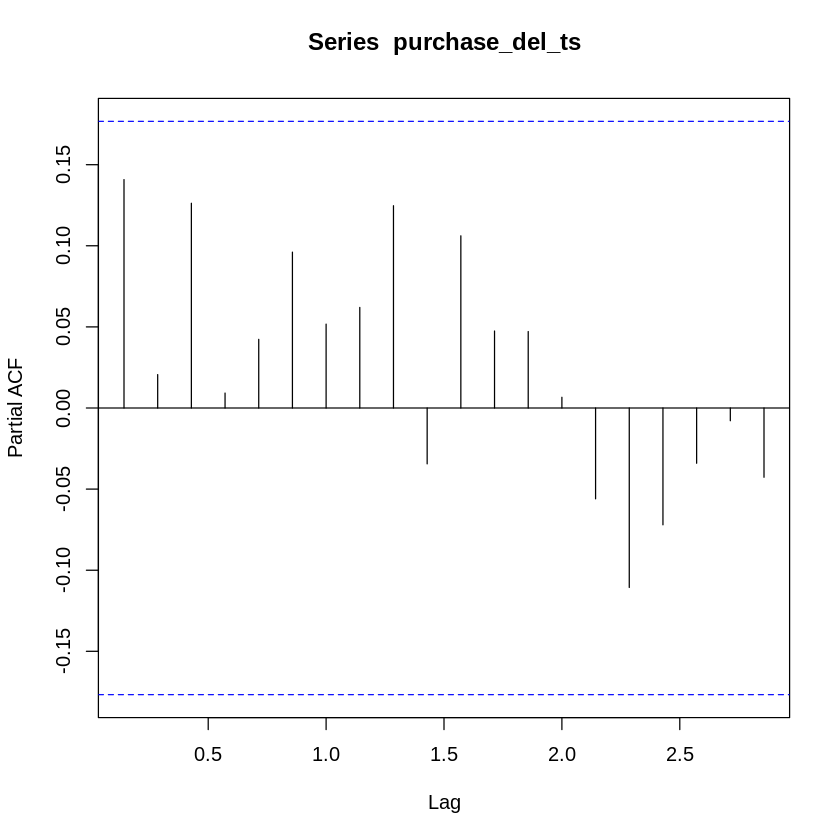

In [12]:
pacf(purchase_del_ts)#p，横轴从1开始

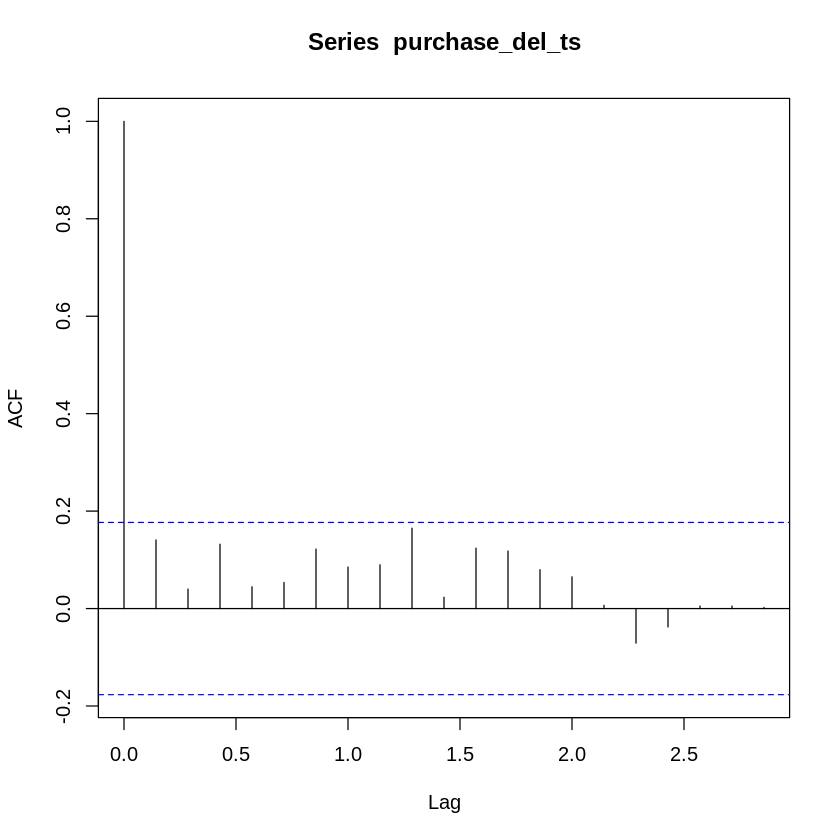

In [13]:
acf(purchase_del_ts)#q

In [14]:
purchase_del_fit = arima(purchase_del_ts/1000,order = c(1,0,1))

In [15]:
purchase_del_fit


Call:
arima(x = purchase_del_ts/1000, order = c(1, 0, 1))

Coefficients:
         ar1      ma1  intercept
      0.9382  -0.8624  17208.817
s.e.  0.0681   0.0929   1438.214

sigma^2 estimated as 58047826:  log likelihood = -1274.04,  aic = 2556.07

In [16]:
for(i in 1:2){print(Box.test(purchase_del_fit$residuals,type = "Ljung-Box",
                             lag = i*6)$p.value)}
for(i in 1:2){print(Box.test(purchase_del_fit$residuals,type = 'Box-Pierce',
                             lag = i*6)$p.value)}

[1] 0.9294434
[1] 0.9421853
[1] 0.9363006
[1] 0.9579793


In [17]:
purchase_pred_test = forecast(purchase_stl_res$time.series[,1],31)$mean+
  predict(purchase_del_fit,n.ahead = 31)$pred*1000

In [18]:
#####redeem
redeem_del_ts=ts(redeem_ts-redeem_stl_res$time.series[,1],
                   frequency=7,start=c(1,1))

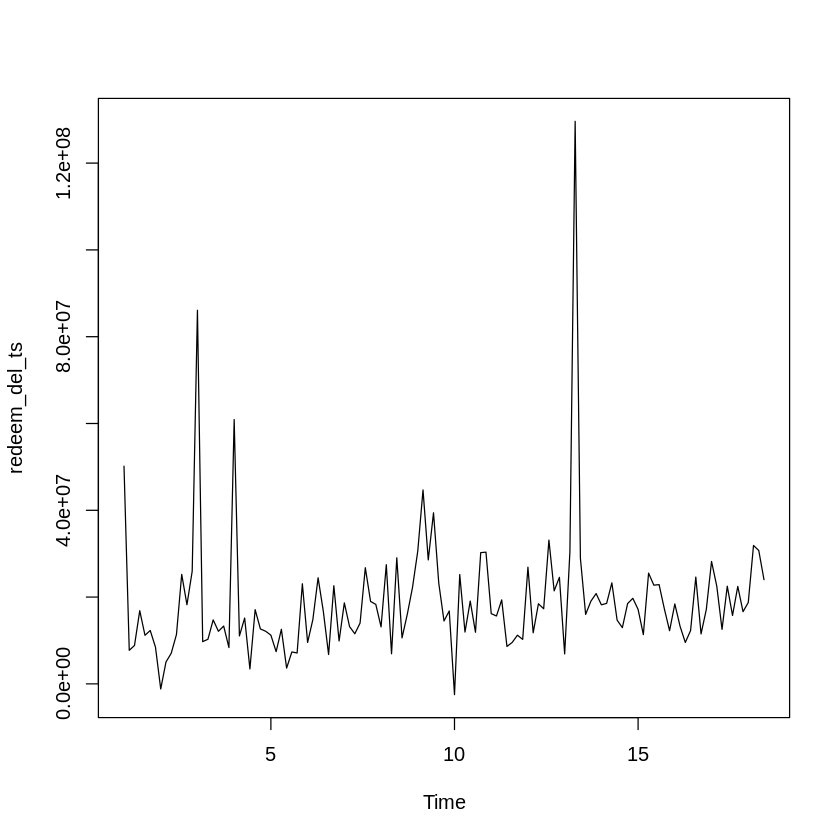

In [19]:
plot(redeem_del_ts)

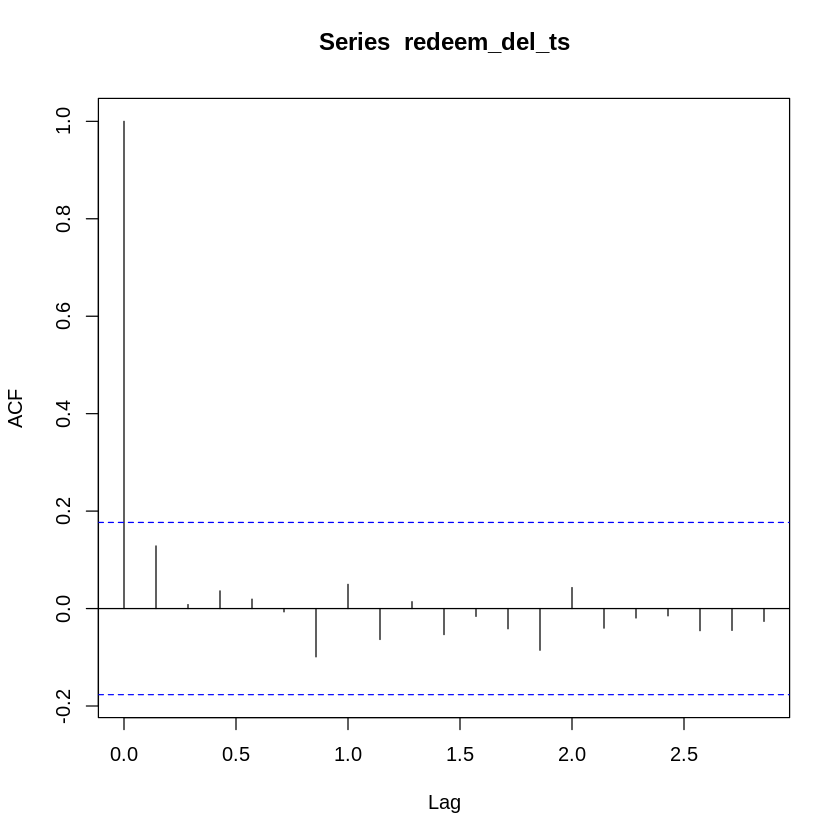

In [20]:
acf(redeem_del_ts)

In [21]:
adf.test(redeem_del_ts)



	Augmented Dickey-Fuller Test

data:  redeem_del_ts
Dickey-Fuller = -4.6163, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


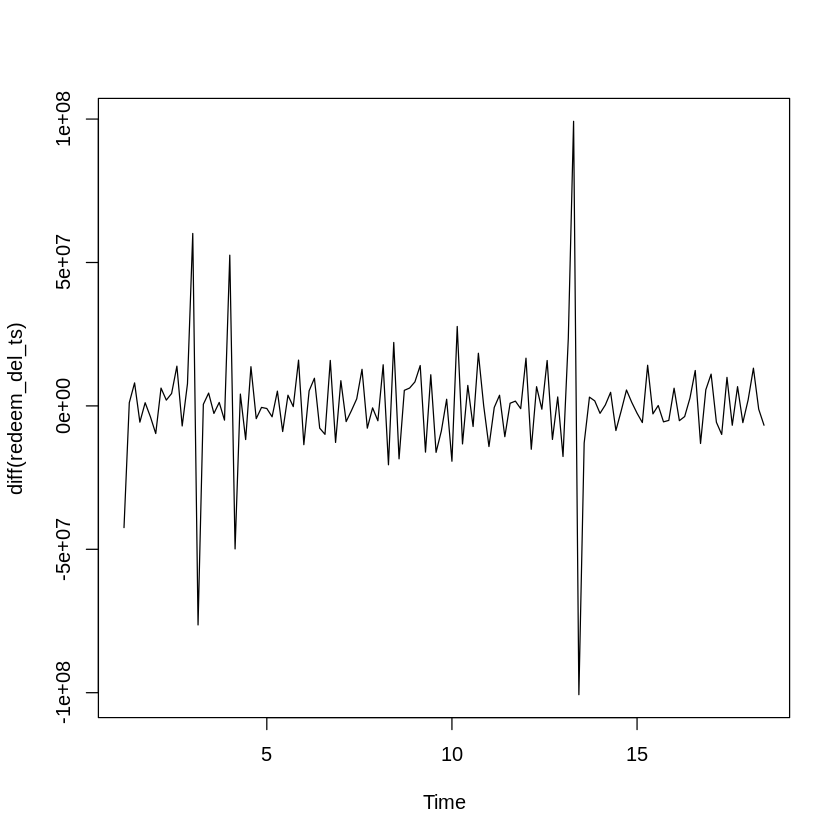

In [22]:
plot(diff(redeem_del_ts))##差分后的时序图

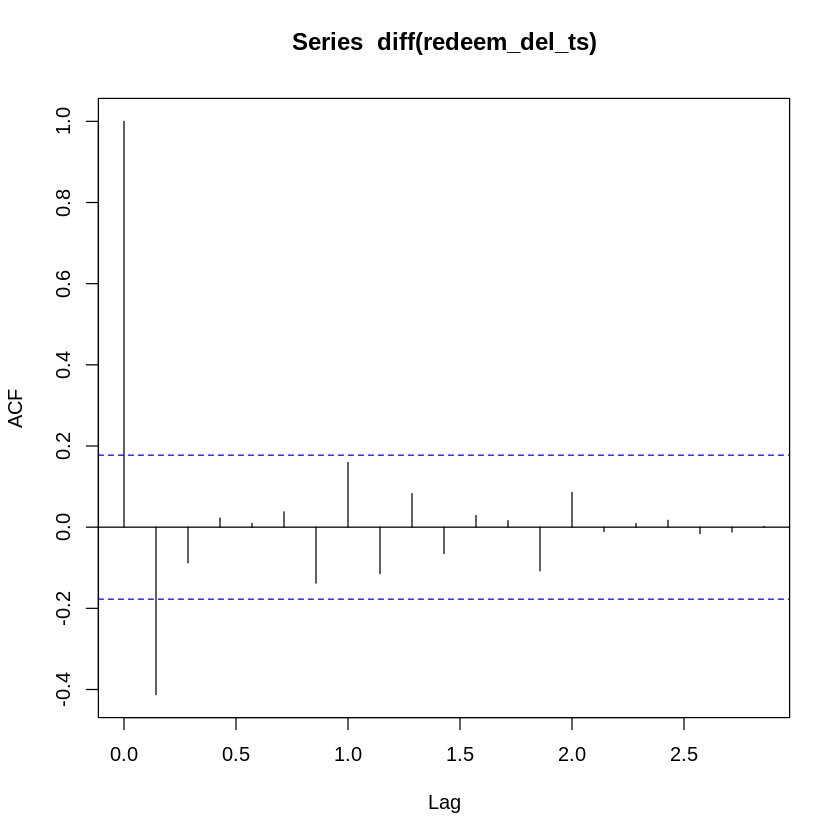

In [23]:
acf(diff(redeem_del_ts))

In [24]:
adf.test(diff(redeem_del_ts))


	Augmented Dickey-Fuller Test

data:  diff(redeem_del_ts)
Dickey-Fuller = -7.1599, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


In [25]:
for(i in 1:2){print(Box.test(diff(redeem_del_ts),type = "Box-Pierce",
                             lag = i*6)$p.value)}

for(i in 1:2){print(Box.test(diff(redeem_del_ts),type = "Ljung-Box",
                             lag = i*6)$p.value)}

[1] 0.0004621225
[1] 0.00237444
[1] 0.0003401795
[1] 0.001527488


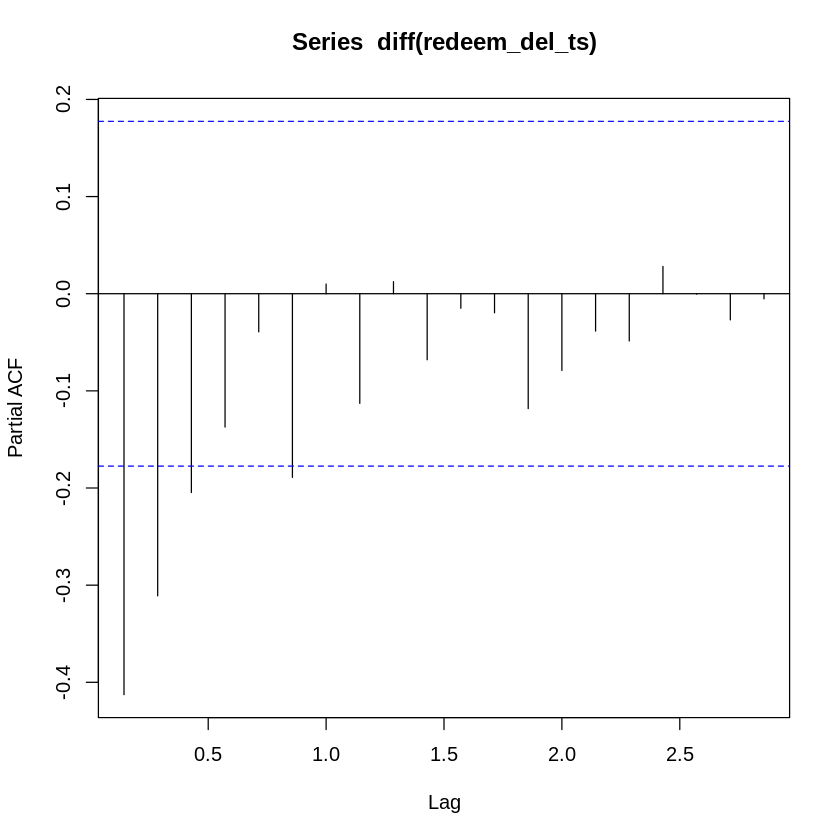

In [26]:
pacf(diff(redeem_del_ts))#拖尾

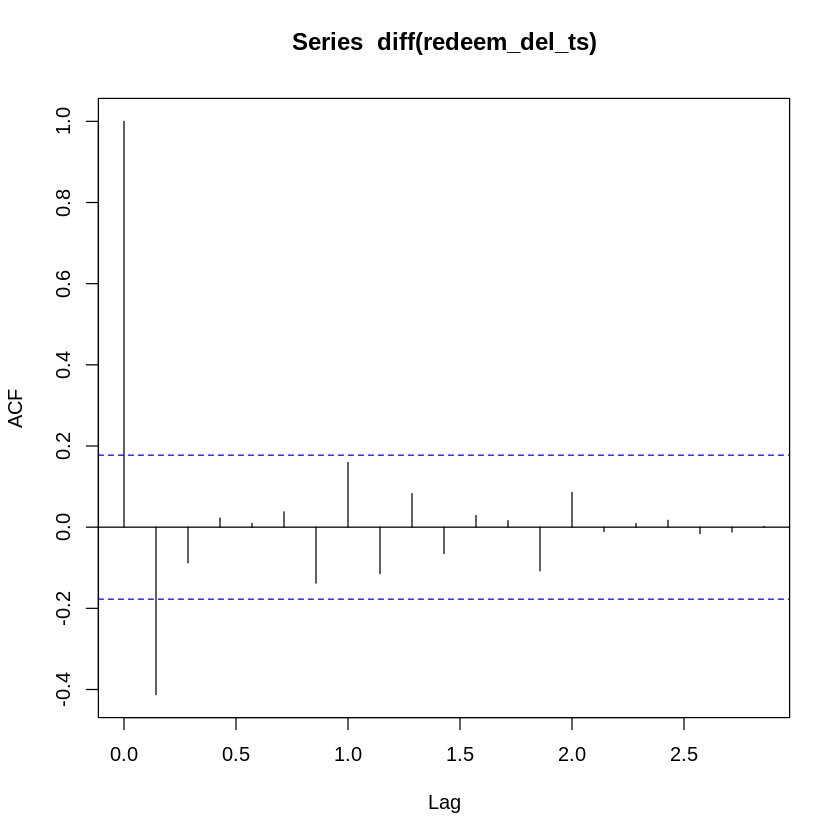

In [27]:
acf(diff(redeem_del_ts)) #截尾

In [28]:
redeem_del_fit = arima(redeem_del_ts,order = c(0,1,1))####建模

In [29]:
###模型显著性检验====
for(i in 1:2){print(Box.test(redeem_del_fit$residuals,
                             type = "Ljung-Box",lag = i*6)$p.value)}


for(i in 1:2){print(Box.test(redeem_del_fit$residuals,
                             type = 'Box-Pierce',lag = i*6)$p.value)}

[1] 0.6562321
[1] 0.8612595
[1] 0.6757362
[1] 0.8864509


In [30]:
redeem_pred_test = predict(redeem_del_fit,n.ahead = 31)$pred+
  forecast(redeem_stl_res$time.series[,1],h=31)$mean

In [31]:
get_score(purchase_pred_test,redeem_pred_test,test_data$total_purchase_amt,
          test_data$total_redeem_amt)

[1] 119.5588

In [32]:
#####去除周期后 auto.arima
#####purchase======
autoFit = auto.arima(purchase_del_ts/1000,d=0,seasonal = F,trace = T )


 ARIMA(2,0,2)           with non-zero mean : 2559.567
 ARIMA(0,0,0)           with non-zero mean : 2557.751
 ARIMA(1,0,0)           with non-zero mean : 2557.403
 ARIMA(0,0,1)           with non-zero mean : 2557.468
 ARIMA(0,0,0)           with zero mean     : 2774.621
 ARIMA(2,0,0)           with non-zero mean : 2559.483
 ARIMA(1,0,1)           with non-zero mean : 2556.413
 ARIMA(2,0,1)           with non-zero mean : Inf
 ARIMA(1,0,2)           with non-zero mean : 2558.418
 ARIMA(0,0,2)           with non-zero mean : 2559.601
 ARIMA(1,0,1)           with zero mean     : Inf

 Best model: ARIMA(1,0,1)           with non-zero mean 



In [33]:
for(i in 1:2){print(Box.test(autoFit$residuals,type = "Ljung-Box",lag = i*6)$p.value)}
for(i in 1:2){print(Box.test(autoFit$residuals,type = 'Box-Pierce',lag = i*6)$p.value)}

[1] 0.9294434
[1] 0.9421853
[1] 0.9363006
[1] 0.9579793


In [34]:
purchase_pred_test = forecast(purchase_stl_res$time.series[,1],31)$mean+
  forecast(autoFit,h=31)$mean*1000

In [35]:
autoFit = auto.arima(redeem_del_ts,d=1,seasonal = F,trace = TRUE)


 ARIMA(2,1,2)           with drift         : Inf
 ARIMA(0,1,0)           with drift         : 4448.339
 ARIMA(1,1,0)           with drift         : 4426.838
 ARIMA(0,1,1)           with drift         : Inf
 ARIMA(0,1,0)                              : 4446.286
 ARIMA(2,1,0)           with drift         : 4415.193
 ARIMA(3,1,0)           with drift         : 4411.113
 ARIMA(4,1,0)           with drift         : 4410.063
 ARIMA(5,1,0)           with drift         : 4411.822
 ARIMA(4,1,1)           with drift         : Inf
 ARIMA(3,1,1)           with drift         : Inf
 ARIMA(5,1,1)           with drift         : Inf
 ARIMA(4,1,0)                              : 4407.851
 ARIMA(3,1,0)                              : 4408.938
 ARIMA(5,1,0)                              : 4409.571
 ARIMA(4,1,1)                              : Inf
 ARIMA(3,1,1)                              : Inf
 ARIMA(5,1,1)                              : Inf

 Best model: ARIMA(4,1,0)                              



In [36]:
###模型显著性检验====
for(i in 1:2){print(Box.test(autoFit$residuals,type = "Ljung-Box",lag = i*6)$p.value)}
for(i in 1:2){print(Box.test(autoFit$residuals,type = 'Box-Pierce',lag = i*6)$p.value)}

[1] 0.4162631
[1] 0.7359182
[1] 0.4537962
[1] 0.7795709


In [37]:
redeem_pred_test = forecast(autoFit,h=31)$mean+
  forecast(redeem_stl_res$time.series[,1],h=31)$mean

In [38]:
get_score(purchase_pred_test,redeem_pred_test,test_data$total_purchase_amt,
          test_data$total_redeem_amt)

[1] 89.89325

In [39]:
holidays_and_effect_days <- data_frame(
  holiday = 'holidays_and_effect_days',
  ds = as.Date(c('2014-04-03', '2014-04-04', 
                 '2014-04-05', '2014-04-06', '2014-04-07', 
                 '2014-04-08', '2014-04-09',
                 
                 '2014-04-29', '2014-04-30', 
                 '2014-05-01', '2014-05-02', '2014-05-03',
                 '2014-05-04', '2014-05-05',
                 
                 '2014-05-29', '2014-05-30',
                 '2014-05-31', '2014-06-01', '2014-06-02', 
                 '2014-06-03', '2014-06-04')),
  lower_window = 0,
  upper_window = 0
)

holidays <- data_frame(
  holiday = 'true_holidays',
  ds = as.Date(c('2014-04-05', '2014-04-06', '2014-04-07',
                 '2014-05-01', '2014-05-02', '2014-05-03',
                 '2014-05-31', '2014-06-01', '2014-06-02')),
  lower_window = 0,
  upper_window = 0
)
holidays <- bind_rows(holidays_and_effect_days, holidays)



###purchase=========

Myprophet_purchase = prophet::prophet(changepoint_prior_scale=0.5,weekly_seasonality=T,
                                      holidays= holidays)
df_purchase = data.frame(train_data$report_date ,train_data$total_purchase_amt )
colnames(df_purchase) <-c('ds','y')
Myprophet_purchase = prophet::fit.prophet(Myprophet_purchase,df_purchase)

future_purchase = prophet::make_future_dataframe(Myprophet_purchase,periods=31,
                                                 include_history=F)
forecast_purchase = predict(Myprophet_purchase, future_purchase)
purchase_pred_test = forecast_purchase$yhat



###redeem=====
Myprophet_redeem = prophet::prophet(changepoint_prior_scale=0.5,weekly_seasonality=True,
                                    holidays= holidays)
df_redeem = data.frame(train_data$report_date ,train_data$total_redeem_amt )
colnames(df_redeem) <-c('ds','y')
df_redeem
Myprophet_redeem = prophet::fit.prophet(Myprophet_redeem,df_redeem)

future_redeem = prophet::make_future_dataframe(Myprophet_redeem,periods=31,
                                               include_history=F)
forecast_redeem = predict(Myprophet_redeem, future_redeem)
redeem_pred_test = forecast_redeem$yhat

get_score(purchase_pred_test,redeem_pred_test,test_data$total_purchase_amt,
          test_data$total_redeem_amt)


ERROR: Error in loadNamespace(name): there is no package called ‘prophet’
